# Amazon Fine Food Reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

In [10]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import datasets, neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import scikitplot as skplt
import pydot
import graphviz
from IPython.display import Image
from sklearn.svm import SVC
from scipy import *
from scipy.sparse import *
from gensim.models import Word2Vec
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
conn = sqlite3.connect('final.sqlite')

In [3]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [4]:
data.shape

(364171, 12)

## Time Based Splitting :

In [5]:
data = data.sort_values(by='Time')
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


In [6]:
# Getting the column names
cols = data.columns
cols = cols[cols != 'Score']
# Train data excluding the score column
X = data[cols]
# Score coumn
Y = data['Score']
# Maping positive as 1 and negative as 0
mapping_dict = {'positive': 1, 'negative': 0}
labels = ['negative', 'positive']
# Mapping is done as some metrics dont work with string so a value of 1 or 0 is given to positive or negative.
Y = Y.map(mapping_dict)

In [7]:
# Getting data :
X_train = X[:80000]
X_cv = X_train[60000:80000]
X_train = X_train[:60000]
X_test =  X[80000:100000]


y_train = Y[:80000]
y_cv = y_train[60000:80000]
y_train = y_train[:60000]
y_test =  Y[80000:100000]

print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

(60000, 11)     (60000,)
(20000, 11)     (20000,)
(20000, 11)     (20000,)


In [8]:
# Feature importance function for Decision Trees :
def feat_importance(vectorizer, model):
    feat_names = vectorizer.get_feature_names()
    weights = model.feature_importances_
    df = pd.DataFrame(data = weights, columns=['Value'], index=feat_names)
    df.sort_values(by='Value', ascending=False, inplace=True)
    return df.head(20)

In [9]:
# Plots confusion matrix using heatmap and calculates and displays TN,FN,TP,FP
def plot_confusion_matrix(y_actual, y_predicted):
    cm = confusion_matrix(y_predicted, y_actual)
    df = pd.DataFrame(data=cm, index=labels, columns=labels)
    print("Confusion Matrix : ")
    plt.figure(figsize=(10,7))
    sns.heatmap(df, annot=True)
    plt.show()
    
    TP = 0 # True Positives
    FP = 0 # False Positives
    TN = 0 # True Negatives
    FN = 0 # False Negatives

    for i in range(len(y_predicted)): 
        if y_actual[i]== 1 and y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_actual[i]!=y_predicted[i]:
            FP += 1
        if y_actual[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_actual[i]!=y_predicted[i]:
            FN += 1
            
    print("True Positives :", TP)
    print("False Positives :", FP)
    print("True Negatives :", TN)
    print("False Negatives :", FN)

## Bag of Words :

In [11]:
cnt_vec = CountVectorizer()
bow_train = cnt_vec.fit_transform(X_train['CleanedText'])
bow_cv = cnt_vec.transform(X_cv['CleanedText'])
bow_test = cnt_vec.transform(X_test['CleanedText'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(60000, 29132)
(20000, 29132)
(20000, 29132)


##### HyperParameter Tuning :

In [12]:
max_depth = [1, 3, 5, 7, 10, 50, 100, 500, 1000]
min_splits = [5, 10, 50, 100, 500]

ticks = []
for x in max_depth:
    for y in min_splits:
        p = 'depth : '
        p += str(x)
        p += ', splitsize : '
        p += str(y)
        ticks.append(p)
        
        
print("Total of Hyperparameter Values to check  : ", len(ticks))

Total of Hyperparameter Values to check  :  45


In [13]:
# For every pair of values train and evaluate the model.
cv_scores = []
tr_scores = []
i = 0
for d in max_depth:
    for sp in min_splits:
        clf = DecisionTreeClassifier(max_depth=d, min_samples_split=sp)
        clf.fit(bow_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(bow_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(bow_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "Max depth : ", d, " MinSplits : ", sp)
        i += 1

CV ROC_AUC Score :  0.550676430039499  Train ROC_AUC Score :  0.544672160292753 Max depth :  1  MinSplits :  5
CV ROC_AUC Score :  0.550676430039499  Train ROC_AUC Score :  0.544672160292753 Max depth :  1  MinSplits :  10
CV ROC_AUC Score :  0.550676430039499  Train ROC_AUC Score :  0.544672160292753 Max depth :  1  MinSplits :  50
CV ROC_AUC Score :  0.550676430039499  Train ROC_AUC Score :  0.544672160292753 Max depth :  1  MinSplits :  100
CV ROC_AUC Score :  0.550676430039499  Train ROC_AUC Score :  0.544672160292753 Max depth :  1  MinSplits :  500
CV ROC_AUC Score :  0.6416249651106731  Train ROC_AUC Score :  0.6351855098141368 Max depth :  3  MinSplits :  5
CV ROC_AUC Score :  0.6416249651106731  Train ROC_AUC Score :  0.6351855098141368 Max depth :  3  MinSplits :  10
CV ROC_AUC Score :  0.6416249651106731  Train ROC_AUC Score :  0.6351855098141368 Max depth :  3  MinSplits :  50
CV ROC_AUC Score :  0.6416249651106731  Train ROC_AUC Score :  0.6351855098141368 Max depth :  3  

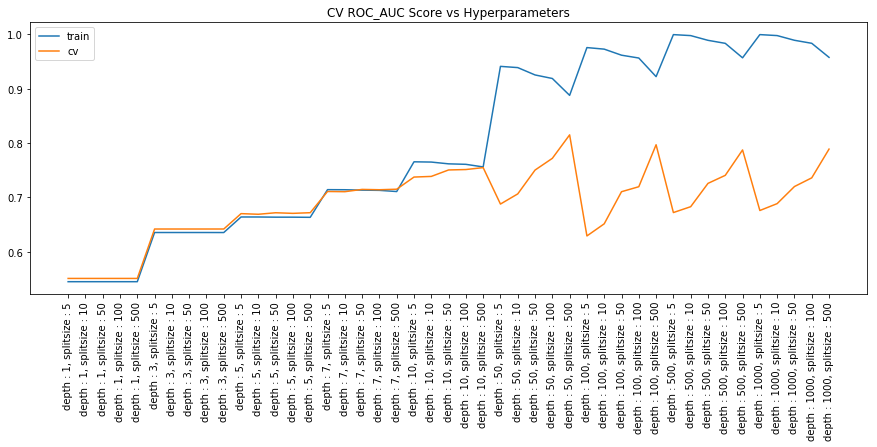

In [14]:
# Visualize the results.
plt.figure(figsize=(15,5))
plt.plot(range(len(ticks)), tr_scores)
plt.plot(range(len(ticks)), cv_scores)
plt.xticks(range(len(ticks)), ticks, rotation = 90)
plt.legend(['train', 'cv'])
plt.title("CV ROC_AUC Score vs Hyperparameters")
plt.show()

In [15]:
# Train Best Model.
model = DecisionTreeClassifier(max_depth=50, min_samples_split=500)
model.fit(bow_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Confusion Matrix : 


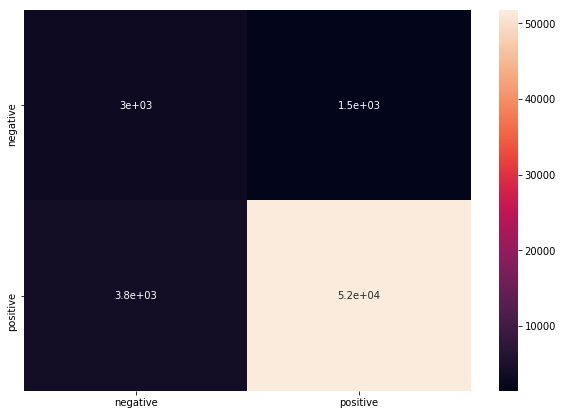

True Positives : 51695
False Positives : 3812
True Negatives : 3041
False Negatives : 1452


In [17]:
# Train Confusion matrix :
plot_confusion_matrix(np.array(y_train), model.predict(bow_train))

##### Feature Importance :

In [16]:
# Using feature_importances_ method of model, function defined above.
feat_importance(cnt_vec, model)

,Value
disappoint,0.085940
great,0.048040
worst,0.047979
money,0.034591
best,0.032884
horribl,0.031753
terribl,0.030805
love,0.028608
return,0.026590
bad,0.021934


##### Visualizing a Small Decision Tree :

In [10]:
vis_vec = CountVectorizer(max_features=10)
visdata = vis_vec.fit_transform(X_train['CleanedText'])
visdata.shape

(60000, 10)

In [11]:
# Fit a small decision tree.
vistree = DecisionTreeClassifier(max_depth=5)
vistree.fit(visdata, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [12]:
# Export the dot file the fitted decision tree.
export_graphviz(vistree, out_file="vistree.dot", feature_names=vis_vec.get_feature_names(),
                class_names=['Negative', 'Positive'], rounded=True, precision=True, filled=True)

Image Generated using https://dreampuf.github.io/GraphvizOnline/#

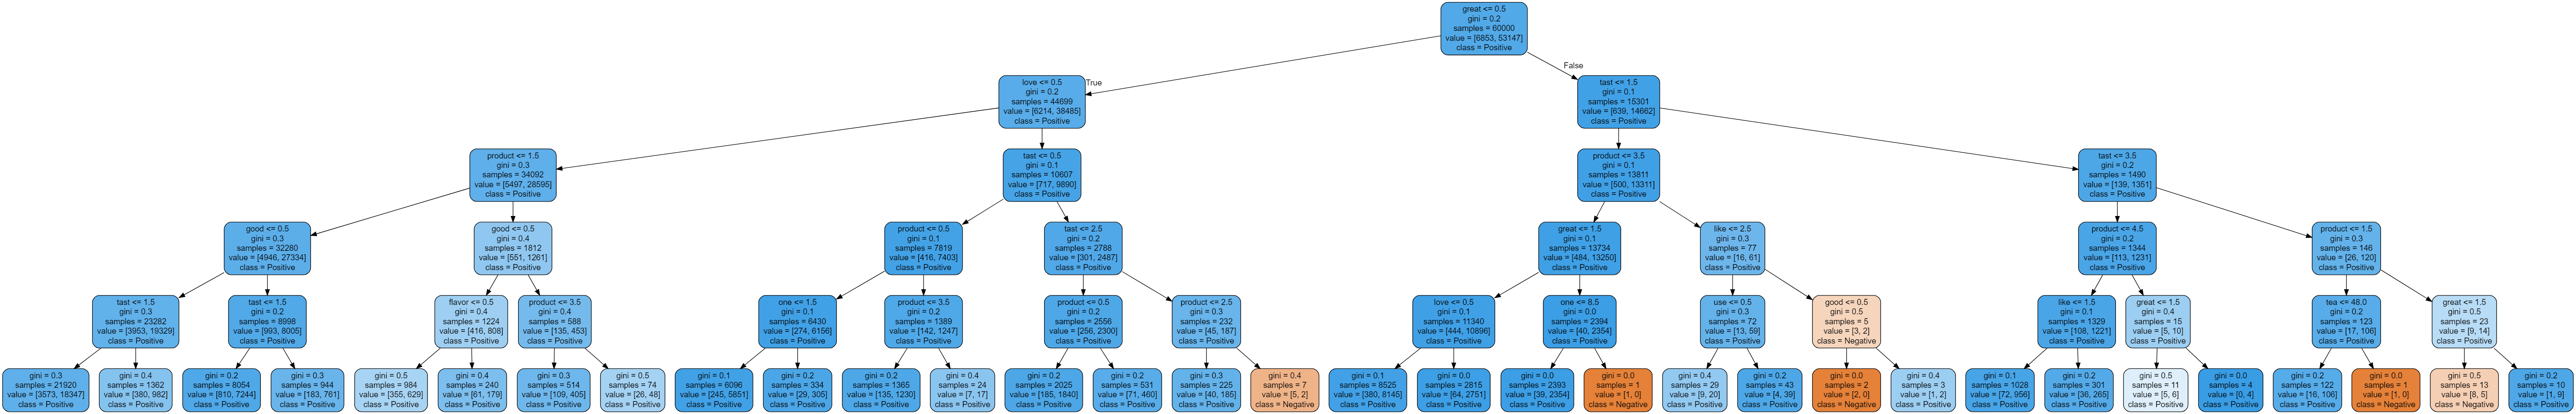

In [17]:
Image(filename="bow.png")

##### Test Metrics :

Confusion Matrix : 


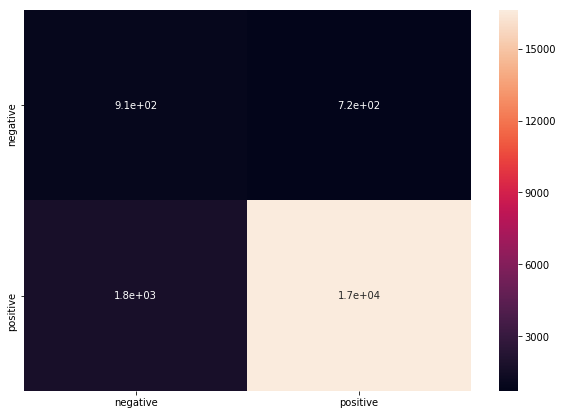

True Positives : 16601
False Positives : 1767
True Negatives : 911
False Negatives : 721


In [18]:
y_pred = model.predict(bow_test)
plot_confusion_matrix(np.array(y_test), y_pred)

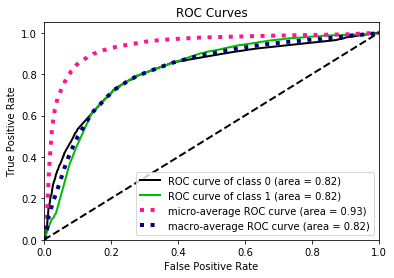

In [25]:
skplt.metrics.plot_roc_curve(np.array(y_test), model.predict_proba(bow_test))
plt.show()

In [26]:
y_pred = model.predict_proba(bow_test)
roc_auc_score(y_test, y_pred[:,1])

0.8158918077560737

### Conclusions for Bag of Words :

1. CV ROC_AUC Score :  0.81
2. Train ROC_AUC Score :  0.88
3. Test ROC_AUC Score : 0.81
4. Max depth :  50
5. MinSplits :  500

## TFIDF :

In [27]:
tfidf_vec = TfidfVectorizer()
tf_train = tfidf_vec.fit_transform(X_train['CleanedText'])
tf_cv = tfidf_vec.transform(X_cv['CleanedText'])
tf_test = tfidf_vec.transform(X_test['CleanedText'])

print(tf_train.shape)
print(tf_cv.shape)
print(tf_test.shape)

(60000, 29132)
(20000, 29132)
(20000, 29132)


In [28]:
# For every pair of values train and evaluate the model.
cv_scores = []
tr_scores = []
i = 0
for d in max_depth:
    for sp in min_splits:
        clf = DecisionTreeClassifier(max_depth=d, min_samples_split=sp)
        clf.fit(tf_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(tf_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(tf_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "Max depth : ", d, " MinSplits : ", sp)
        i += 1

CV ROC_AUC Score :  0.5496047990797676  Train ROC_AUC Score :  0.5444718947313933 Max depth :  1  MinSplits :  5
CV ROC_AUC Score :  0.5496047990797676  Train ROC_AUC Score :  0.5444718947313933 Max depth :  1  MinSplits :  10
CV ROC_AUC Score :  0.5496047990797676  Train ROC_AUC Score :  0.5444718947313933 Max depth :  1  MinSplits :  50
CV ROC_AUC Score :  0.5496047990797676  Train ROC_AUC Score :  0.5444718947313933 Max depth :  1  MinSplits :  100
CV ROC_AUC Score :  0.5496047990797676  Train ROC_AUC Score :  0.5444718947313933 Max depth :  1  MinSplits :  500
CV ROC_AUC Score :  0.6408233775405774  Train ROC_AUC Score :  0.6353744249802311 Max depth :  3  MinSplits :  5
CV ROC_AUC Score :  0.6408233775405774  Train ROC_AUC Score :  0.6353744249802311 Max depth :  3  MinSplits :  10
CV ROC_AUC Score :  0.6408233775405774  Train ROC_AUC Score :  0.6353744249802311 Max depth :  3  MinSplits :  50
CV ROC_AUC Score :  0.6408233775405774  Train ROC_AUC Score :  0.6353744249802311 Max de

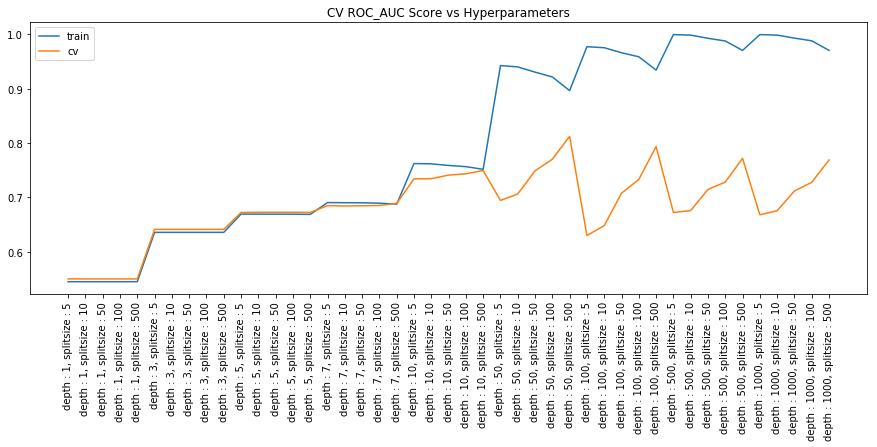

In [29]:
# Visualize the results.
plt.figure(figsize=(15,5))
plt.plot(range(len(ticks)), tr_scores)
plt.plot(range(len(ticks)), cv_scores)
plt.xticks(range(len(ticks)), ticks, rotation = 90)
plt.legend(['train', 'cv'])
plt.title("CV ROC_AUC Score vs Hyperparameters")
plt.show()

In [30]:
# Train Best Model.
model = DecisionTreeClassifier(max_depth=50, min_samples_split=500)
model.fit(tf_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Confusion Matrix : 


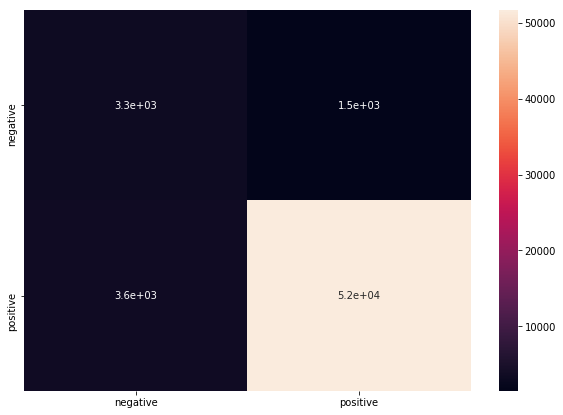

True Positives : 51633
False Positives : 3558
True Negatives : 3295
False Negatives : 1514


In [31]:
# Train Confusion matrix :
plot_confusion_matrix(np.array(y_train), model.predict(tf_train))

##### Feature importance :

In [32]:
# Using feature_importances_ method of model, function defined above.
feat_importance(tfidf_vec, model)

,Value
disappoint,0.081019
great,0.046623
worst,0.046475
wast,0.032636
best,0.031270
bad,0.028357
terribl,0.027829
horribl,0.027271
return,0.025670
love,0.023116


##### Visualizing the Decision Tree :

In [28]:
vis_vec = TfidfVectorizer(max_features=10)
visdata = vis_vec.fit_transform(X_train['CleanedText'])
visdata.shape

(60000, 10)

In [29]:
# Fit a small decision tree.
vistree = DecisionTreeClassifier(max_depth=5)
vistree.fit(visdata, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
# Export the dot file the fitted decision tree.
export_graphviz(vistree, out_file="vistree2.dot", feature_names=vis_vec.get_feature_names(),
                class_names=['Negative', 'Positive'], rounded=True, precision=True, filled=True)

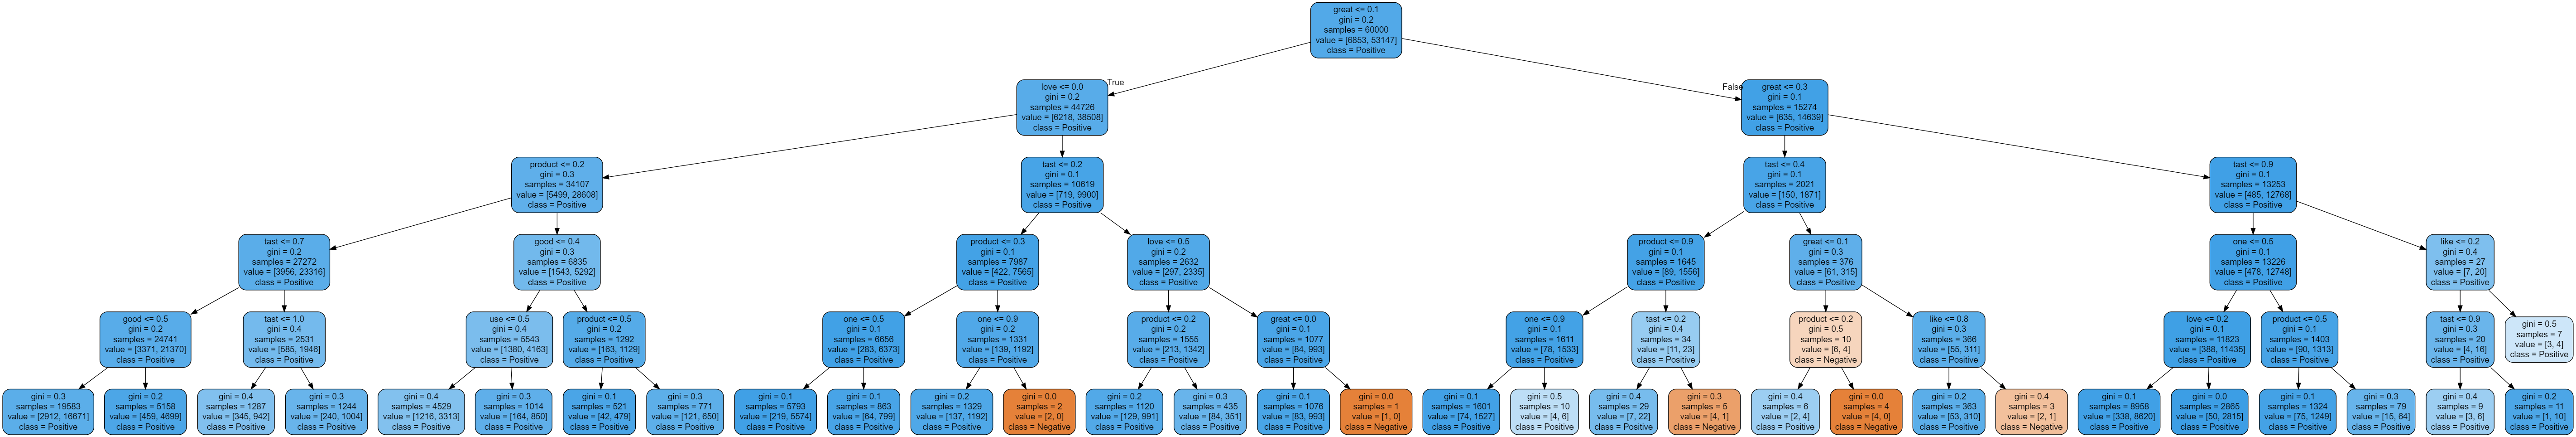

In [31]:
Image(filename="tfidf.png")

##### Test Metrics :

Confusion Matrix : 


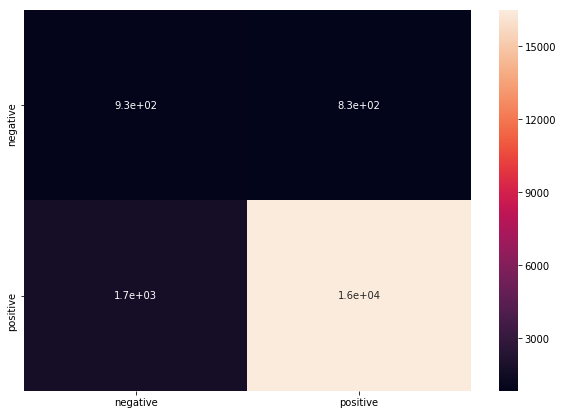

True Positives : 16490
False Positives : 1747
True Negatives : 931
False Negatives : 832


In [33]:
y_pred = model.predict(tf_test)
plot_confusion_matrix(np.array(y_test), y_pred)

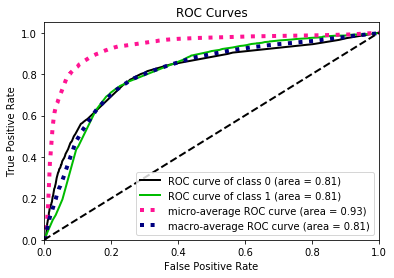

In [34]:
# ROC_AUC Score
skplt.metrics.plot_roc_curve(np.array(y_test), model.predict_proba(tf_test))
plt.show()

In [35]:
y_pred = model.predict_proba(tf_test)
roc_auc_score(y_test, y_pred[:,1])

0.8093564120758339

### Conclusions for TFIDF :

1. CV ROC_AUC Score :  0.81
2. Train ROC_AUC Score :  0.89
3. Test ROC_AUC Score :  0.80
4. Max depth :  50
5. MinSplits :  500

## AVGW2V :

Loading already present avgw2v features :

In [36]:
train_avgw2v = np.load("train_avgw2v.npy")
cv_avgw2v = np.load("cv_avgw2v.npy")
test_avgw2v = np.load("test_avgw2v.npy")

y_train = np.load("y_train.npy")
y_cv = np.load("y_cv.npy")
y_test = np.load("y_test.npy")

print(train_avgw2v.shape)
print(cv_avgw2v.shape)
print(test_avgw2v.shape)

(60000, 50)
(20000, 50)
(20000, 50)


In [37]:
# For every pair of values train and evaluate the model.
cv_scores = []
tr_scores = []
i = 0
for d in max_depth:
    for sp in min_splits:
        clf = DecisionTreeClassifier(max_depth=d, min_samples_split=sp)
        clf.fit(train_avgw2v, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(cv_avgw2v)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(train_avgw2v)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "Max depth : ", d, " MinSplits : ", sp)
        i += 1

CV ROC_AUC Score :  0.6847167832463568  Train ROC_AUC Score :  0.684872863121638 Max depth :  1  MinSplits :  5
CV ROC_AUC Score :  0.6847167832463568  Train ROC_AUC Score :  0.684872863121638 Max depth :  1  MinSplits :  10
CV ROC_AUC Score :  0.6847167832463568  Train ROC_AUC Score :  0.684872863121638 Max depth :  1  MinSplits :  50
CV ROC_AUC Score :  0.6847167832463568  Train ROC_AUC Score :  0.684872863121638 Max depth :  1  MinSplits :  100
CV ROC_AUC Score :  0.6847167832463568  Train ROC_AUC Score :  0.684872863121638 Max depth :  1  MinSplits :  500
CV ROC_AUC Score :  0.7691927984200422  Train ROC_AUC Score :  0.7707044203290675 Max depth :  3  MinSplits :  5
CV ROC_AUC Score :  0.7691927984200422  Train ROC_AUC Score :  0.7707044203290675 Max depth :  3  MinSplits :  10
CV ROC_AUC Score :  0.7691927984200422  Train ROC_AUC Score :  0.7707044203290675 Max depth :  3  MinSplits :  50
CV ROC_AUC Score :  0.7691927984200422  Train ROC_AUC Score :  0.7707044203290675 Max depth :

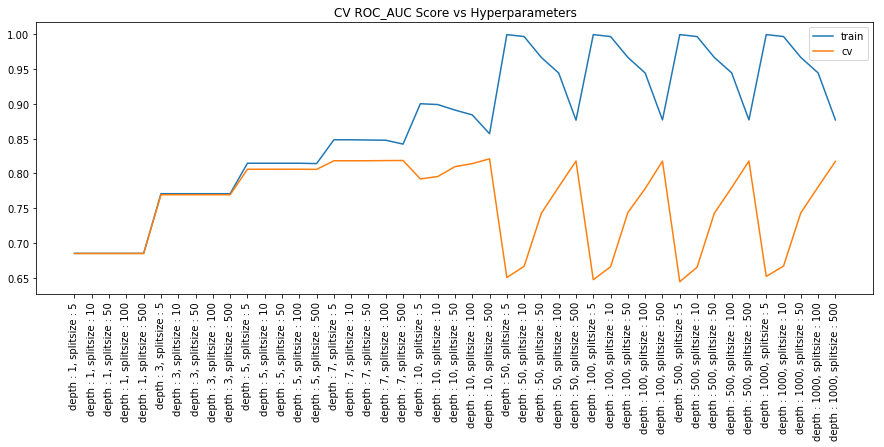

In [38]:
# Visualize the results.
plt.figure(figsize=(15,5))
plt.plot(range(len(ticks)), tr_scores)
plt.plot(range(len(ticks)), cv_scores)
plt.xticks(range(len(ticks)), ticks, rotation = 90)
plt.legend(['train', 'cv'])
plt.title("CV ROC_AUC Score vs Hyperparameters")
plt.show()

In [39]:
# Train Best Model.
model = DecisionTreeClassifier(max_depth=10, min_samples_split=500)
model.fit(train_avgw2v, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Confusion Matrix : 


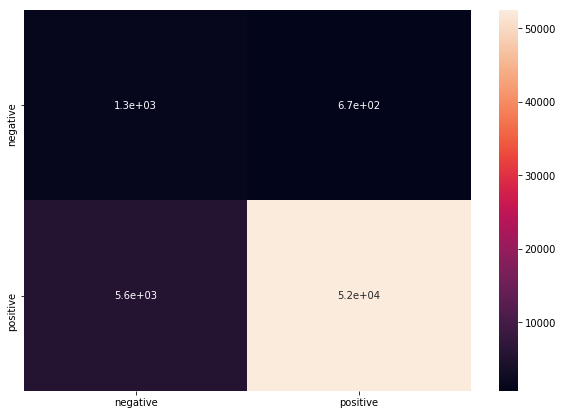

True Positives : 52477
False Positives : 5559
True Negatives : 1294
False Negatives : 670


In [40]:
# Train Confusion matrix :
plot_confusion_matrix(np.array(y_train), model.predict(train_avgw2v))

##### Test Metrics :

Confusion Matrix : 


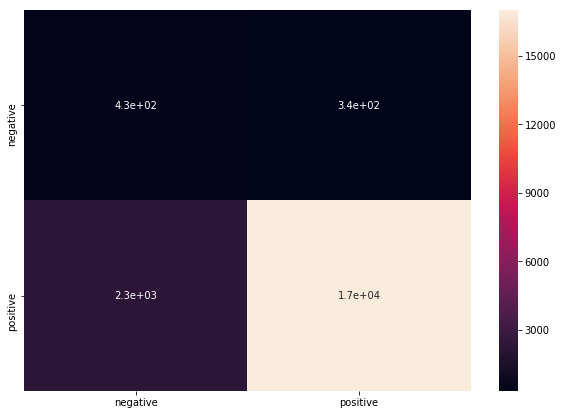

True Positives : 16984
False Positives : 2252
True Negatives : 426
False Negatives : 338


In [41]:
y_pred = model.predict(test_avgw2v)
plot_confusion_matrix(np.array(y_test), y_pred)

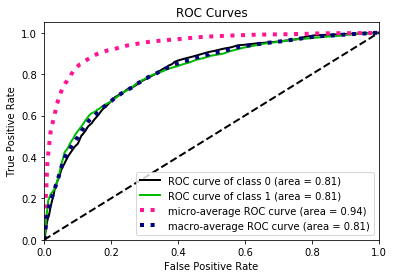

In [42]:
# ROC_AUC Score
skplt.metrics.plot_roc_curve(np.array(y_test), model.predict_proba(test_avgw2v))
plt.show()

In [43]:
y_pred = model.predict_proba(test_avgw2v)
roc_auc_score(y_test, y_pred[:,1])

0.8140191055868464

### Conclusions for AVGW2V :

1. CV ROC_AUC Score :  0.82
2. Train ROC_AUC Score :  0.85
3. Test ROC_AUC Score : 0.81
4. Max depth :  10
5. MinSplits :  500 

## TFIDFW2V :

In [44]:
train_tfidf = np.load("train_tfidf.npy")
cv_tfidf = np.load("cv_tfidf.npy")
test_tfidf = np.load("test_tfidf.npy")

print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

(60000, 50)
(20000, 50)
(20000, 50)


In [45]:
# For every pair of values train and evaluate the model.
cv_scores = []
tr_scores = []
i = 0
for d in max_depth:
    for sp in min_splits:
        clf = DecisionTreeClassifier(max_depth=d, min_samples_split=sp)
        clf.fit(train_tfidf, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(cv_tfidf)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(train_tfidf)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "Max depth : ", d, " MinSplits : ", sp)
        i += 1

CV ROC_AUC Score :  0.6428178734849574  Train ROC_AUC Score :  0.6501022025667154 Max depth :  1  MinSplits :  5
CV ROC_AUC Score :  0.6428178734849574  Train ROC_AUC Score :  0.6501022025667154 Max depth :  1  MinSplits :  10
CV ROC_AUC Score :  0.6428178734849574  Train ROC_AUC Score :  0.6501022025667154 Max depth :  1  MinSplits :  50
CV ROC_AUC Score :  0.6428178734849574  Train ROC_AUC Score :  0.6501022025667154 Max depth :  1  MinSplits :  100
CV ROC_AUC Score :  0.6428178734849574  Train ROC_AUC Score :  0.6501022025667154 Max depth :  1  MinSplits :  500
CV ROC_AUC Score :  0.7269581898994342  Train ROC_AUC Score :  0.7344322156000936 Max depth :  3  MinSplits :  5
CV ROC_AUC Score :  0.7269581898994342  Train ROC_AUC Score :  0.7344322156000936 Max depth :  3  MinSplits :  10
CV ROC_AUC Score :  0.7269581898994342  Train ROC_AUC Score :  0.7344322156000936 Max depth :  3  MinSplits :  50
CV ROC_AUC Score :  0.7269581898994342  Train ROC_AUC Score :  0.7344322156000936 Max de

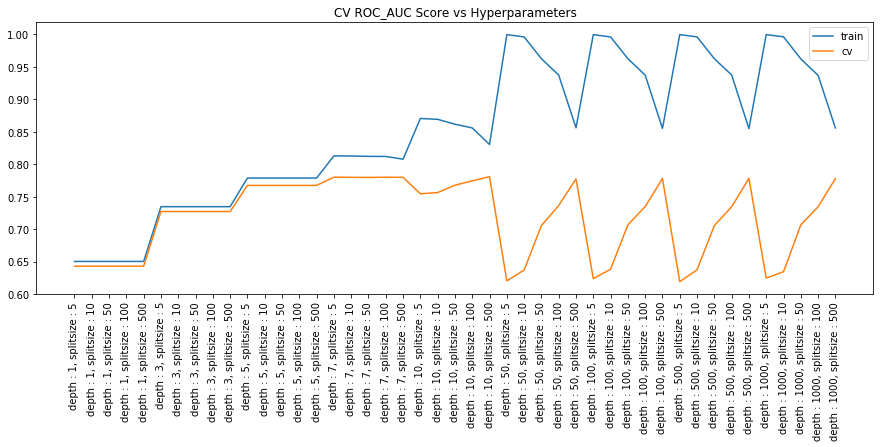

In [46]:
# Visualize the results.
plt.figure(figsize=(15,5))
plt.plot(range(len(ticks)), tr_scores)
plt.plot(range(len(ticks)), cv_scores)
plt.xticks(range(len(ticks)), ticks, rotation = 90)
plt.legend(['train', 'cv'])
plt.title("CV ROC_AUC Score vs Hyperparameters")
plt.show()

In [47]:
# Train Best Model.
model = DecisionTreeClassifier(max_depth=50, min_samples_split=500)
model.fit(train_tfidf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Confusion Matrix : 


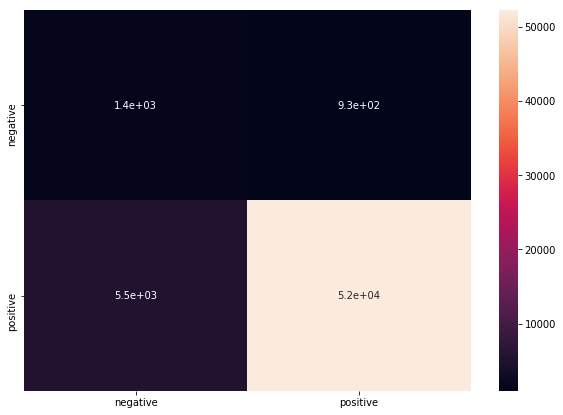

True Positives : 52213
False Positives : 5456
True Negatives : 1397
False Negatives : 934


In [48]:
# Train Confusion matrix :
plot_confusion_matrix(np.array(y_train), model.predict(train_tfidf))

##### Test Metrics :

Confusion Matrix : 


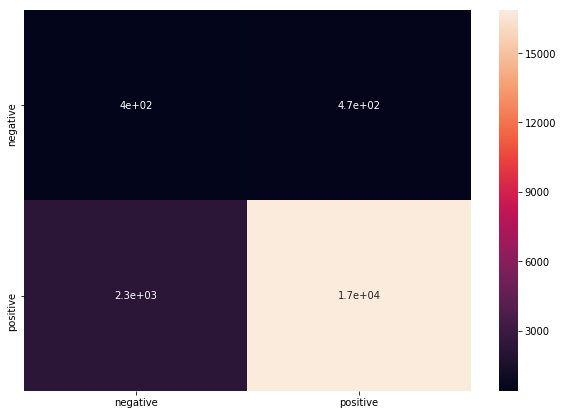

True Positives : 16851
False Positives : 2279
True Negatives : 399
False Negatives : 471


In [49]:
y_pred = model.predict(test_tfidf)
plot_confusion_matrix(np.array(y_test), y_pred)

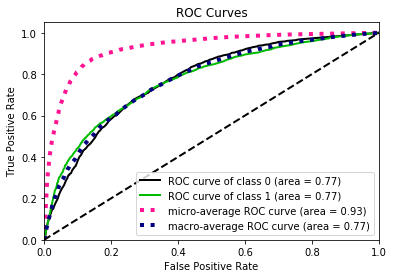

In [50]:
# ROC_AUC Score
skplt.metrics.plot_roc_curve(np.array(y_test), model.predict_proba(test_tfidf))
plt.show()

In [51]:
y_pred = model.predict_proba(test_tfidf)
roc_auc_score(y_test, y_pred[:,1])

0.772204050261277

### Conclusions for TFIDFW2V :

1. CV ROC_AUC Score :  0.77
2. Train ROC_AUC Score :  0.85
3. Test ROC_AUC Score : 0.77
4. Max depth :  50
5. MinSplits :  500

## Results :

<table><tr><th>Featurization</th><th>Train ROC_AUC</th><th>Test ROC_AUC</th><th>CV ROC_AUC</th><th>Max Depth</th><th>Min Samples Split</th></tr><tr><td>BOW</td><td>0.88<br></td><td>0.81<br></td><td>0.81<br></td><td>50<br></td><td>500</td></tr><tr><td>TFIDF </td><td>0.89<br></td><td>0.80<br></td><td>0.81<br></td><td>50</td><td>500</td></tr><tr><td>AVG-W2V</td><td>0.85<br></td><td>0.81<br></td><td>0.82<br></td><td>10</td><td>500</td></tr><tr><td>TFIDF-W2V</td><td>0.85<br></td><td>0.77<br></td><td>0.77<br></td><td>50</td><td>500</td></tr></table>